In [11]:
import sympy as sym
import numpy as np
import scipy as sp
from scipy import linalg,spatial

import matplotlib.pyplot as plt

In [12]:
# podatki
ρ = 2700 # kg /m3
E = 70e9 # Pa
L = 1 # m

b = 0.030 # m
h = 0.030 # m
A = b*h # m^2
I = b*h**3/12 # m^4

In [13]:
# transformacijska matrika
def T(α):
    
    T = np.array([[ np.cos(α), np.sin(α), 0,         0,         0, 0],
                   [-np.sin(α), np.cos(α), 0,         0,         0, 0],
                   [         0,         0, 1,         0,         0, 0],
                   [         0,         0, 0, np.cos(α), np.sin(α), 0],
                   [         0,         0, 0,-np.sin(α), np.cos(α), 0],
                   [         0,         0, 0,         0,         0, 1]])
        
    return T

In [14]:
# masna matrika
def M_e(A, L, ρ, α):

    M_lok = ρ*A*L*np.array([[1/3,         0,         0, 1/6,         0,         0],
                            [  0,     13/35,  11*L/210,   0,      9/70, -13*L/420],
                            [  0,  11*L/210,  L**2/105,   0,  13*L/420, -L**2/140],
                            [1/6,         0,         0, 1/3,         0,         0],
                            [  0,      9/70,  13*L/420,   0,     13/35, -11*L/210],
                            [  0, -13*L/420, -L**2/140,   0, -11*L/210,  L**2/105]])
    
    return T(α).T @ M_lok @ T(α)

In [15]:
# togostna matrika
def K_e(A, E, I, L, α):

    K_lok = E/L*np.array([[ A,          0,      0, -A,          0,      0],
                          [ 0,  12*I/L**2,  6*I/L,  0, -12*I/L**2,  6*I/L],
                          [ 0,      6*I/L,    4*I,  0,     -6*I/L,    2*I],
                          [-A,          0,      0,  A,          0,      0],
                          [ 0, -12*I/L**2, -6*I/L,  0,  12*I/L**2, -6*I/L],
                          [ 0,      6*I/L,    2*I,  0,     -6*I/L,    4*I]])
    
    return T(α).T @ K_lok @ T(α)

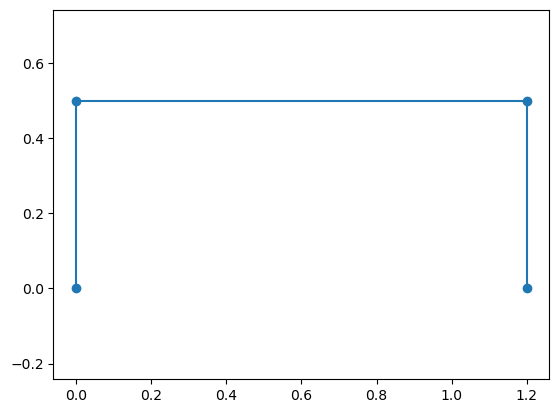

In [16]:
# vozlišča in elementi
%matplotlib inline
a = 1.2*L
b = 0.5*L
vozlisca = np.array([[0,0],[0,b],[a,b],[a,0]])
elementi = np.array([[0,1],[1,2],[2,3]])

[plt.plot(vozlisca[[i,j],0],vozlisca[[i,j],1],'-',c='C0') for i,j in elementi]
plt.plot(vozlisca[:,0],vozlisca[:,1],'o');
plt.axis('equal');

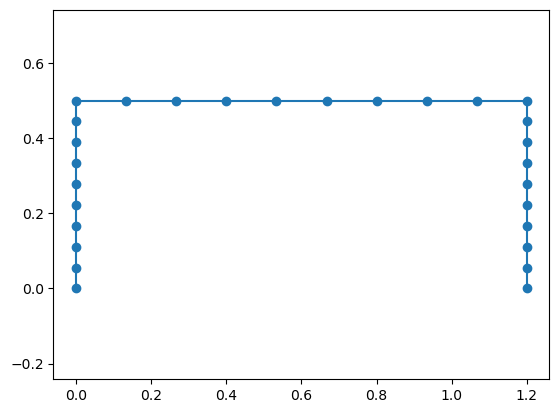

In [17]:
n = 10
vozlisca_AB = np.array([[0,y] for y in np.linspace(0,b,n)])
vozlisca_BC = np.array([[x,b] for x in np.linspace(0,a,n)])
vozlisca_CD = np.array([[a,y] for y in np.linspace(b,0,n)])

vozlisca = np.vstack([vozlisca_AB, vozlisca_BC[1:], vozlisca_CD[1:]])
elementi = np.array([[i,i+1] for i in range(len(vozlisca)-1)])

[plt.plot(vozlisca[[i,j],0],vozlisca[[i,j],1],'-',c='C0') for i,j in elementi]
plt.plot(vozlisca[:,0],vozlisca[:,1],'o');
plt.axis('equal');

In [18]:
# sestav globalne masne in togostne matrike
M_glob = np.zeros((vozlisca.shape[0]*3,vozlisca.shape[0]*3))
K_glob = np.zeros((vozlisca.shape[0]*3,vozlisca.shape[0]*3))

for element in elementi:
    # dolžina elementa
    Le = sp.spatial.distance.euclidean(vozlisca[element[0]], vozlisca[element[1]])
    #Le = np.linalg.norm(vozlisca[element])
    
    # kot zasuka
    αe = np.arctan2(np.diff(vozlisca[element,1]) , np.diff(vozlisca[element,0]))[0]
    
    # indeksi prostostnih stopenj
    ind = np.array([3*element[0],3*element[0]+1,3*element[0]+2,3*element[1],3*element[1]+1,3*element[1]+2])
    
    # priševanje prispevkov posameznih elementov
    M_glob[ind[:,None],ind] += M_e(A, Le, ρ, αe)
    K_glob[ind[:,None],ind] += K_e(A, E, I, Le, αe)

In [19]:
# ROBNI POGOJI
ind_vpetih_ps = np.array([0,1,2,-2])

C = np.zeros((len(ind_vpetih_ps),len(M_glob)))
C[np.arange(len(ind_vpetih_ps)),ind_vpetih_ps] = 1

L = sp.linalg.null_space(C)

M_glob_rp = L.T @ M_glob @ L
K_glob_rp = L.T @ K_glob @ L

In [20]:
# lastne vrednosti in lastni vektorji
eig_val, eig_vec = sp.linalg.eig(K_glob_rp, M_glob_rp)

# urejanje po velikosti
_ind = np.argsort(np.abs(eig_val))
eig_val = np.abs(eig_val[_ind])
eig_vec = eig_vec[:,_ind]

# masno normiranje
m_rr = np.diagonal(eig_vec.T @ M_glob_rp @ eig_vec)
Φ = eig_vec / m_rr**0.5

ω_r = eig_val**0.5

### Harmonska analiza

In [21]:
# # amplitudi vzbujevalnih sil
# F1x = 300; 

# f_glob = np.zeros(3*len(vozlisca)) # pazi na robne pogoje

# # izbrana lokacija vzbujanja
# tocka_B = np.array([0,b])
# ind_vozlisca = np.where((vozlisca[:,None] == tocka_B).all(2).flatten())[0]
# ind_x, ind_y, ind_phi = 3*ind_vozlisca + np.array([0,1,2])
# f_glob[ind_x] = F1x 

# f_glob = np.linalg.pinv(L)@ f_glob # prehod v svet Q
# h_r = Φ.T @ f_glob

In [23]:
# amplitudi vzbujevalnih sil
F1x = 300; 

f_glob = np.zeros(3*len(vozlisca)) # pazi na robne pogoje

# izbrana lokacija vzbujanja
tocka_B = np.array([0,b])
ind_vozlisca = np.where((vozlisca == tocka_B).all(axis = 1))[0]
ind_x, ind_y, ind_phi = 3*ind_vozlisca + np.array([0,1,2])
f_glob[ind_x] = F1x 

# f_glob = np.linalg.pinv(L)@ f_glob # prehod v svet Q
h_r = Φ.T @ L.T @ f_glob

In [24]:
n_modes = len(ω_r)

δ = 0.003
ω = np.arange(2000)
H_i = np.zeros([n_modes,ω.shape[0]])
phi_i = np.zeros([n_modes,ω.shape[0]])

for i in range(n_modes):
    H_i[i] = h_r[i]/ω_r[i]**2 * 1/((1-(ω/ω_r[i])**2)**2+(2*δ*ω/ω_r[i])**2)**0.5
    phi_i[i] = -np.arctan2(-2*δ*ω/ω_r[i], 1-(ω/ω_r[i])**2)
    
# prehod v fizikalni prostor
H_fiz = L @ Φ @ (H_i*np.exp(1.j*phi_i))

In [25]:
ω_r[:10]

array([ 168.5127898 ,  377.05597731,  606.68652747, 1501.6636002 ,
       2708.1377848 , 3442.01898944, 3756.10291256, 5494.52944611,
       7858.52642339, 9516.65546943])

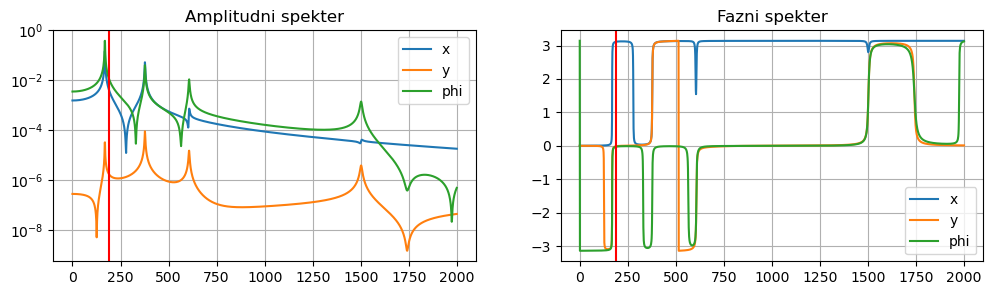

In [26]:
ind_vozlisca = 9
ind_x, ind_y, ind_phi = 3*ind_vozlisca + np.array([0,1,2])

# odziv pri specifični vzbujevalni frekvenci
ω_vzb = 190 # rad/s

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title('Amplitudni spekter')
plt.semilogy(ω, np.abs(H_fiz[ind_x]),label='x')
plt.semilogy(ω, np.abs(H_fiz[ind_y]),label='y')
plt.semilogy(ω, np.abs(H_fiz[ind_phi]),label='phi')
plt.axvline(ω_vzb,c='red')
plt.legend()
plt.grid()

plt.subplot(122)
plt.title('Fazni spekter')
plt.plot(ω, np.angle(H_fiz[ind_x]),label='x')
plt.plot(ω, np.angle(H_fiz[ind_y]),label='y')
plt.plot(ω, np.angle(H_fiz[ind_phi]),label='phi')
plt.axvline(ω_vzb,c='red')
plt.legend()
plt.grid()

In [27]:
H_fiz.shape

(84, 2000)

In [28]:
odziv = H_fiz[:, np.where(ω == ω_vzb)[0]].real.flatten()

pomiki_x = odziv[0::3]
pomiki_y = odziv[1::3]

def_vozlisca = np.copy(vozlisca)
def_vozlisca[:,0] += pomiki_x
def_vozlisca[:,1] += pomiki_y

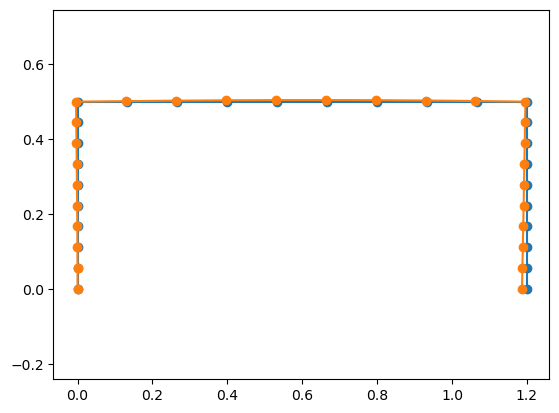

In [29]:
%matplotlib inline
# nedeformirana geometrija
[plt.plot(vozlisca[[i,j],0],vozlisca[[i,j],1],'-',c='C0') for i,j in elementi]
plt.plot(vozlisca[:,0],vozlisca[:,1],'o');
# deformirana geometrija
[plt.plot(def_vozlisca[[i,j],0],def_vozlisca[[i,j],1],'-',c='C1') for i,j in elementi]
plt.plot(def_vozlisca[:,0],def_vozlisca[:,1],'o');
plt.axis('equal');